In this assignment we will look at a typical image based machine learning task.

## Image classification 

For this task the whole image is used to classify what's happening.

For this specific task, we will be trying to classify COVID-19 using pneumonia x-rays.  Please note, the literature has mostly suggested CT scans are not an effective way of figuring out what type of disease you have.  This exercise is for academic purposes _only_.

Steps:


1. Download the pneumonia data.  

You can find it here:

https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

move the folder to this directory and unzip it.  Please don't change any folder names or the below script will not work.  Also make sure the folder is in the same directory as this notebook!

2. load the pneumonia data into a dataframe:

In [1]:
import numpy as np
import pandas as pd
import os
import os.path as op
import numpy as np
import glob
from PIL import Image
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import skimage.transform
import skimage.color
from sklearn.metrics import classification_report

In [2]:
import glob

def load_training_data():
    paths = [
        "chest_xray/train/NORMAL/*",
        "chest_xray/train/PNEUMONIA/*"
    ]
    labels = []
    image_paths = []
    for path in paths:
        for im_path in glob.glob(path):
            if path == "chest_xray/train/NORMAL/*":
                labels.append("NORMAL")
            if path == "chest_xray/train/PNEUMONIA/*":
                labels.append("PNEUMONIA")
            image_paths.append(im_path)
    return image_paths, labels

def load_testing_data():
    paths = [
        "chest_xray/test/NORMAL/*",
        "chest_xray/test/PNEUMONIA/*"
    ]
    labels = []
    image_paths = []
    for path in paths:
        for im_path in glob.glob(path):
            if path == "chest_xray/test/NORMAL/*":
                labels.append("NORMAL")
            if path == "chest_xray/test/PNEUMONIA/*":
                labels.append("PNEUMONIA")
            image_paths.append(im_path)
    return image_paths, labels

train_paths, train_labels = load_training_data()
test_paths, test_labels = load_training_data()

In [3]:
train_paths[:5]

['chest_xray/train/NORMAL\\IM-0115-0001.jpeg',
 'chest_xray/train/NORMAL\\IM-0117-0001.jpeg',
 'chest_xray/train/NORMAL\\IM-0119-0001.jpeg',
 'chest_xray/train/NORMAL\\IM-0122-0001.jpeg',
 'chest_xray/train/NORMAL\\IM-0125-0001.jpeg']

3. read the data into memory, I recommend open-cv for this:

`python -m pip install opencv-python` 

if you don't already have it!

In [4]:
import cv2
import os

def load_images(image_paths):
    loadedImages = []
    
    for img in image_paths:
        img = cv2.imread(img)
        loadedImages.append(img)
    return loadedImages

In [6]:
#load train images
train_images = load_images(train_paths)
#load test images
test_images = load_images(test_paths)

4. resize the images to a standard size - 

Note: it ought to be a box.  So the width and height should be the same size.

In [86]:
def resize_images(images):
    resizedimages = []
    for img in images:
        img = cv2.resize(img,(100,100), interpolation = cv2.INTER_LINEAR)
        resizedimages.append(img)
    return resizedimages

In [87]:
train_images = resize_images(train_images)
test_images = resize_images(test_images)

In [88]:
train_images[0].shape

(100, 100, 3)

5. Greyscale the images

In [16]:
def greyscale_images(images):
    grayimages=[]
    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        grayimages.append(img)
    return grayimages

In [17]:
train_images = greyscale_images(train_images)
test_images = greyscale_images(test_images)

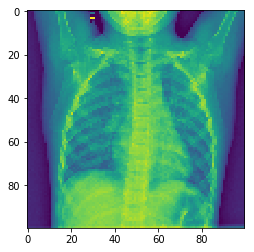

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(train_images[0])

In [118]:
train_labels_np = np.array(train_labels)
test_labels_np = np.array(test_labels)

6. prepare the data for training the model.

For this you'll need to transform the test and train image objects into a numpy array.

In [4]:
def features_to_np_array(image_paths, shape):
    height, width, channels = shape
    array = np.zeros((len(image_paths), height, width, channels))
    for i, path in enumerate(image_paths):
        im = Image.open(path)
        as_array = np.asarray(im)
        if len(as_array.shape) == 2: 
            as_array = skimage.color.gray2rgb(as_array)
        resized = skimage.transform.resize(as_array, shape)
        array[i,:,:] = resized
        if (i + 1) % 1000 == 0:
            print(f'{i+1} images loaded')
            i= i+1
    return array

Next you'll need to do the same for the labels:

Note: You'll need to apply the `to_categorical` function after transforming to a numpy array

In [90]:
train_labels_np = np.where(train_labels_np=='NORMAL',0,1)
test_labels_np = np.where(train_labels_np=='NORMAL',0,1)

C:\Users\sonali\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
label_type = { label: i for i, label in enumerate(set(train_labels)) }
label_type

{'PNEUMONIA': 0, 'NORMAL': 1}

In [6]:
def labels_to_np_array(labels, mapping):
    return np.array([mapping[label] for label in labels])

In [7]:
image_shape = (100, 100, 3)
X_value = features_to_np_array(train_paths, image_shape)
Y_value = labels_to_np_array(train_labels, label_type)

1000 images loaded
2000 images loaded
3000 images loaded
4000 images loaded
5000 images loaded


7. Seperate into train and test with `train_test_split` from scikit-learn

In [8]:
# train test split code goes here
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_value, Y_value, test_size=0.33, random_state=42)

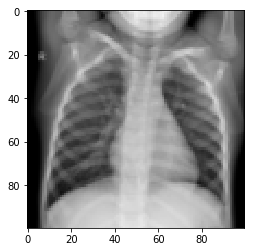

In [9]:
plt.imshow(X_train[0])

8. Make the last four layers of VGG16 with imagenet weights trainable and then retrain the model.

To understand how to do this, please see the following tutorial:

https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/

In [10]:
# your model and training code goes here
from tensorflow.keras.applications import VGG16
from tensorflow.python.framework import ops
ops.reset_default_graph()
#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape =image_shape )

In [11]:
#Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x0000023CDE892CF8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000023CD65474E0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000023CDE96CE48> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000023CDEAE7668> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000023CDEAE7FD0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000023CDEB13470> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000023CDE8BDAC8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000023CDEB199E8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000023CDEB44550> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000023CDEB4CA90> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000023CDF183F98> False
<tensorflow.python.

In [12]:
from tensorflow.keras import models,layers,optimizers

model = models.Sequential()
model.add(vgg_conv)
 
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              4719616   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 19,437,379
Trainable params: 11,802,115
Non-trainable params: 7,635,264
_________________________________________________________________


In [13]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])
model.fit(X_train, Y_train, epochs= 5, batch_size= 128, validation_split=0.2)

Train on 2795 samples, validate on 699 samples
Epoch 1/5
2795/2795 [==============================] - 277s 99ms/sample - loss: 0.5069 - acc: 0.8186 - val_loss: 0.1196 - val_acc: 0.9542
Epoch 2/5
2795/2795 [==============================] - 304s 109ms/sample - loss: 0.1572 - acc: 0.9377 - val_loss: 0.1048 - val_acc: 0.9599
Epoch 3/5
2795/2795 [==============================] - 300s 107ms/sample - loss: 0.1196 - acc: 0.9589 - val_loss: 0.1793 - val_acc: 0.9213
Epoch 4/5
2795/2795 [==============================] - 298s 107ms/sample - loss: 0.0978 - acc: 0.9624 - val_loss: 0.0678 - val_acc: 0.9757
Epoch 5/5
2795/2795 [==============================] - 299s 107ms/sample - loss: 0.0480 - acc: 0.9814 - val_loss: 0.0568 - val_acc: 0.9785


8. Check your score with classification_report from scikit-learn

Now that you've trained your model, call `model.predict` to get the predicted values for classification.  
Then compare your predicted values with y_test

In [14]:
y_pred = model.predict_classes(X_test)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1261
           1       0.98      0.95      0.96       461

    accuracy                           0.98      1722
   macro avg       0.98      0.97      0.98      1722
weighted avg       0.98      0.98      0.98      1722



9. Data augmentation

Now that you have a classifier, let's see if data augmentation improves things!  

You can use the `ImageDataGenerator` that comes with keras.  Here's how to import it:

`from tensorflow.keras.preprocessing.image import ImageDataGenerator`

Here's the documentation: https://keras.io/preprocessing/image/

Here's an example of it getting used in the wild, in case you get stuck:

https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/

In [28]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.2
)

train_gen.fit(X_train)

10. retrain your classifier

Now that you have augmented training data, please retrain your classifier.  The code should basically be the same.

In [29]:
# new training code goes here
augmented_model = tf.keras.models.Sequential()

augmented_model.add(vgg_conv)

augmented_model.add(tf.keras.layers.Flatten())
augmented_model.add(tf.keras.layers.Dense(1024, activation='relu'))
augmented_model.add(tf.keras.layers.Dropout(0.5))
augmented_model.add(tf.keras.layers.Dense(2, activation='softmax'))

augmented_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              4719616   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2050      
Total params: 19,436,354
Trainable params: 11,801,090
Non-trainable params: 7,635,264
_________________________________________________________________


In [30]:
#augmented_model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])
augmented_model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4),metrics=['acc'])

In [33]:
augmented_model.fit(
        train_gen.flow(X_train, Y_train, batch_size= 128, subset='training'),
        steps_per_epoch = (X_train.shape[0] * (1 - 0.2)) // 128, epochs=5, verbose=1,
        validation_data=train_gen.flow(X_train, Y_train, batch_size=128, subset='validation'),
        validation_steps=(X_train.shape[0] * 0.2) // 128)

Train for 21.0 steps, validate for 5.0 steps
Epoch 1/5
21/21 [==============================] - 266s 13s/step - loss: 0.4903 - acc: 0.7935 - val_loss: 0.2172 - val_acc: 0.9203
Epoch 2/5
21/21 [==============================] - 271s 13s/step - loss: 0.2452 - acc: 0.8932 - val_loss: 0.1305 - val_acc: 0.9484
Epoch 3/5
21/21 [==============================] - 270s 13s/step - loss: 0.1911 - acc: 0.9228 - val_loss: 0.2005 - val_acc: 0.9094
Epoch 4/5
21/21 [==============================] - 273s 13s/step - loss: 0.1854 - acc: 0.9284 - val_loss: 0.1424 - val_acc: 0.9438
Epoch 5/5
21/21 [==============================] - 275s 13s/step - loss: 0.1690 - acc: 0.9292 - val_loss: 0.3044 - val_acc: 0.8391


11. re-evaluate your classifier

Now that you've augmented the data, please re-evaluate your classifer.  Use classification report like before.

In [34]:
# classification report goes here
y_pred = augmented_model.predict_classes(X_test)
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      1.00      0.85      1261
           1       1.00      0.00      0.00       461

    accuracy                           0.73      1722
   macro avg       0.87      0.50      0.43      1722
weighted avg       0.80      0.73      0.62      1722



12. Evaluate the difference with data augmentation and without:

Did things improve?  Did they stay the same?  Did they get worse?  Please try to come up with an explanation of why you got the results you did.

* Yes thing improved using data agumentation improvement in the precision and recall after doing data agumentation 
* Result without data  augmentation acc was 96% but the model was overfitting due to small no of images
* with data augmentation acc was less compares to previous model 

### Explanation of results go here

13. Getting COVID19 data

Now that you have a trained classifier with pneumonia, we are going to use this with COVID data.  

Clone this repo:

https://github.com/ieee8023/covid-chestxray-dataset

use the clone command: `git clone [REPO]`

to get the data locally.  

Make sure to run this command in the same folder as this jupyter notebook.

14. Read the data into memory

The set up for this data repository is a little different.  Please use the following code to read the data into memory:

In [16]:
import pandas as pd

def get_covid19():
    base = "covid-chestxray-dataset/"
    metadata = pd.read_csv(base+"metadata.csv")
    labels = []
    image_paths = []
    for index, row in metadata.iterrows():
        labels.append(row["finding"])
        image_paths.append(base+row["filename"])
    return labels, image_paths

labels, covid_image_paths = get_covid19()

In [108]:
covid_image_paths[:10]

['covid-chestxray-dataset/images/auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
 'covid-chestxray-dataset/images/auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
 'covid-chestxray-dataset/images/auntminnie-c-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
 'covid-chestxray-dataset/images/auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
 'covid-chestxray-dataset/images/nejmc2001573_f1a.jpeg',
 'covid-chestxray-dataset/images/nejmc2001573_f1b.jpeg',
 'covid-chestxray-dataset/images/ARDSSevere.png',
 'covid-chestxray-dataset/images/lancet-case2a.jpg',
 'covid-chestxray-dataset/images/lancet-case2b.jpg',
 'covid-chestxray-dataset/images/SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0.jpeg']

In [17]:
#covid_image_paths
label_list = []
image_path_list = []
for (label, image_path) in zip(labels, covid_image_paths):
    if (label == 'COVID-19') or (label == 'No Finding'):
        label_list.append(label)
        image_path_list.append(image_path)


15. preprocess images

you'll need to run the following functions on this data:

1. load_images
2. resize_images
3. greyscale_images
4. features_to_np_array
5. labels_to_np_array

Make sure to run each of those functions in order!

In [26]:
import cv2
import os
def load_images(image_paths):
    images = []
    for image_path in image_paths:
        image = preprocess_images(image_path)
        images.append(image)
    return np.stack(np.array(images), 0)


In [25]:
img_size =100
def preprocess_images(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (img_size, img_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img = np.array(img)/255.0
    return img


In [165]:
#load train images
train_covid = load_images(covid_image_paths)

In [102]:
# add your function calls to covid_image_paths here
def get_image_features(image_paths, shape):
    height, width, channels = shape
    array = np.zeros((len(image_paths), height, width, channels))
    for i, path in enumerate(image_paths):
        im = Image.open(path)
        as_array = np.asarray(im)
        if len(as_array.shape) == 2: # convert to 3 channels (required input to VGG)
            as_array = skimage.color.gray2rgb(as_array)
        resized = skimage.transform.resize(as_array, shape)
        array[i,:,:] = resized
        if (i + 1) % 500 == 0:
            print(f'Finished loading {i+1} samples')
    return array

In [103]:
categorical = { label: i for i, label in enumerate(set(labels)) }
categorical

{'Streptococcus': 0,
 'COVID-19, ARDS': 1,
 'ARDS': 2,
 'Legionella': 3,
 'SARS': 4,
 'No Finding': 5,
 'Chlamydophila': 6,
 'Pneumocystis': 7,
 'Klebsiella': 8,
 'COVID-19': 9,
 'E.Coli': 10}

In [149]:
def labels_to_np_array(labels, mapping):
    return np.array([mapping[label] for label in labels])

16. Strip out labels other than 'No Finding' and 'COVID-19' from the dataset

There are two straight forward ways to do this:

1) use a for-loop and keep track of indices

2) read labels and features into a dataframe and then filter to those two label types.  Your choice!

In [172]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.2
)

train_gen.fit(X_train)

In [6]:
#labels = pd.DataFrame(labels)
#lables = np.where(labels =='COVID-19' or 'No Finding ')

In [173]:
model = tf.keras.models.Sequential()

model.add(augmented_model)

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 2)                 19436354  
_________________________________________________________________
flatten_5 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 1024)              3072      
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 2050      
Total params: 19,441,476
Trainable params: 11,806,212
Non-trainable params: 7,635,264
_________________________________________________________________


In [28]:
#prediction code goes here
take_only = 300
import cv2
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import glob
import code

def extract_features_covid(model, width, height):
    base = "covid-chestxray-dataset/"
    im_base = "covid-chestxray-dataset/images/"
    metadata = pd.read_csv(base+"metadata.csv")
    labels = []
    feature_list = []
    image_paths = []
    for index, row in metadata.iterrows():
        if row["finding"] == "COVID-19" and ".gz" not in row["filename"]:
            labels.append("COVID")
            im_path = im_base+row["filename"]
            image_paths.append(im_path)
            im = np.expand_dims(preprocess_images(im_path), axis=0)
            features = model.predict(im)
            features_np = np.array(features)
            feature_list.append(features_np.flatten())

    return np.array(feature_list), labels

def extract_features_not_covid(model, width, height):
    feature_list = []
    labels = []
    paths = [
      "chest_xray/test/NORMAL/*",
      "chest_xray/test/PNEUMONIA/*",
      "chest_xray/train/NORMAL/*",
      "chest_xray/train/PNEUMONIA/*"
    ] 
    count_train = 0
    count_test = 0
    count_pneumonia = 0
    count_data = 0
    for path in paths:
        for im_path in glob.glob(path):
            count = False
            if path == "chest_xray/train/NORMAL/*" and count_train < take_only:
                labels.append("CLEAR TRAIN")
                count_train += 1
                count = True
            if path == "chest_xray/test/NORMAL/*" and count_test < take_only:
                labels.append("CLEAR TEST")
                count_test += 1
                count = True
            if path == "chest_xray/train/PNEUMONIA/*" and count_pneumonia < take_only:
                labels.append("PNEUMONIA")
                count_pneumonia += 1
                count = True
            if count:
               # im = np.expand_dims(get_image_features(im_path), axis=0)
                im = np.expand_dims(preprocess_images(im_path), axis=0)
                features = model.predict(im)
                features_np = np.array(features)
                feature_list.append(features_np.flatten())

    return np.array(feature_list), labels

# please make a copy of your tuned model and save it to variable:
untuned_model = model

# please specify the width and height you used for the image preprocessing
width = 100
height = 100

covid_features, covid_labels = extract_features_covid(untuned_model, width, height)
non_covid_features, non_covid_labels = extract_features_not_covid(untuned_model, width, height)

covid_features = (covid_features > 0.5)
covid_features = np.argmax(covid_features, axis=1) 

non_covid_features = (non_covid_features > 0.5)
non_covid_features = np.argmax(non_covid_features, axis=1) 

features = np.concatenate([covid_features, non_covid_features])
labels = np.concatenate([covid_labels, non_covid_labels])

X_train_bl = []
y_train_bl = []
X_test_bl = []
y_test_bl = []
for index, label in enumerate(labels):
    if label == "CLEAR TRAIN":
        X_train_bl.append(features[index])
        y_train_bl.append(0)
    if label == "PNEUMONIA":
        X_train_bl.append(features[index])
        y_train_bl.append(1)
    if label == "COVID":
        X_test_bl.append(features[index])
        y_test_bl.append(1)
    if label == "CLEAR TEST":
        X_test_bl.append(features[index])
        y_test_bl.append(0)

X_train_bl = np.array(X_train_bl).reshape(-1, 1)
y_train_bl = np.array(y_train_bl).reshape(-1, 1)
X_test_bl = np.array(X_test_bl).reshape(-1, 1)
y_test_bl = np.array(y_test_bl).reshape(-1, 1)

logit_clf = LogisticRegression()
logit_clf.fit(X_train_bl, y_train_bl)
y_pred = logit_clf.predict(X_test_bl)
print(classification_report(y_test_bl, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.43      0.55       234
           1       0.68      0.90      0.78       319

    accuracy                           0.70       553
   macro avg       0.72      0.66      0.66       553
weighted avg       0.71      0.70      0.68       553



C:\Users\sonali\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


17. Predict on the new images

Here you'll use the classifier you trained on just pneumonia/not pneumonia to try and classify COVID-19 and no finding.  You'll use the pneumonia/not pneumonia classifier as a featurizer to do this.

Much of the code has been written, you'll just need to supply your trained classifier as input.

Please predict the labels from the classifier.  Then run `classification_report` to see how well your classifier did.

18. Compare and contrast how the classifier did on Pneumonia versus COVID-19

Did it do as well?  Worse?  About the same?  What conclusions can you draw?

### Add your answers here!

Now that we've looked at a bunch of base cases, let's see if we can improve things by changing the model architecture.  We'll do this with a bunch of discrete steps

1. Change the number of trainable layers

Here you will make more of the layers trainable.  For this we are going to use cross validation to try and figure out which the optimal number of trainable layers.  Please us from the last 6 layers to one layer.  So your range should be:

```
trainable_range = [-6, -5, -4, -3, -2, -1]
```

Also, your X and y data should be the pneumonia data only.  Since that's what we trained on.  We should not assume we have access to the COVID data, except for testing, which will do later on.

Here's a blog post detailing how to set this up: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

Note you'll need to set the number of trainable layers inside of `model_create` in order to make this tunable.  

Please report mean and standard deviation for accuracy.

In [30]:

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from tensorflow.keras.callbacks import EarlyStopping

In [31]:
# Cross validation code goes here
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [33]:
def create_model(activation='relu', dropout_rate=0.5, optimizer='adam', trainable_range=-4):
    keras.backend.clear_session()
    baseModel = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_size, img_size, 3)))

    # Freeze the layers last 4 layers
    for layer in baseModel.layers[:trainable_range]:
        layer.trainable = False
        model1 = baseModel.output
        model1 = AveragePooling2D(pool_size=(3, 3))(model1)
        model1 = Flatten(name="flatten")(model1)
        model1 = Dense(64, activation=activation)(model1)
        model1 = Dropout(dropout_rate)(model1)
        model1 = Dense(2, activation="softmax")(model1)

        model = Model(inputs=baseModel.input, outputs=model1)
        model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
        return model

In [36]:
model = KerasClassifier(build_fn=create_model, batch_size=20, epochs=10, verbose=0)
trainable_range = [-3, -2, -1]

param_grid = dict(trainable_range=trainable_range)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, verbose=0)

In [38]:
grid_result = grid.fit(X_train, Y_train)


KeyboardInterrupt: 

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [40]:
cvscores=[]
Y_val = (Y_train > 0.5)
Y_val = np.argmax(Y_val, axis=0)
trainable_range = grid_result.best_params_['trainable_range']
for train, test in kfold.split(X_train, Y_val):
    model = create_model(trainable_range=trainable_range)
    model.fit(datagen.flow(X_train[train], Y_train[train]),
                                batch_size=20,
                                callbacks=[es],
                                epochs=10,
                                steps_per_epoch=len(X_train[train]) / 32,
                                verbose=0)
    scores = model.evaluate(X_train[test], Y_train[test])
    cvscores.append(scores)

NameError: name 'grid_result' is not defined

In [ ]:
score_mean = np.mean(cvscores, axis=0)
score_std = np.std(cvscores, axis=0)
for index in range(0, 2):
    print("%s: %.2f%% (+/- %.2f%%)" % (model.metrics_names[index], score_mean[index]*100, score_std[index]*100))

2. Analyze your results

Do you think that changing the number of tunable layers matters?  Does it improve classification accuracy enough to warrant changing the number of tunable layers?  

### Analysis and explanation go here

2. Tune over a layer activation function

Please set the number of tunable layers to 4 again.

Now we are going to make the layer activation tunable.  

To do this, please change the model_create function so that each layer has it's own tunable activation function.  Then run your new cross validation code.

In [41]:
# cross validation code goes here
model = KerasClassifier(build_fn=create_model, batch_size=20, epochs=10, verbose=0)
activation = ['relu', 'tanh', 'sigmoid', 'linear']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, verbose=0)

In [ ]:
grid_result = grid.fit(X_train, Y_train)

3. Analyze your results

Does your choice of activation function matter?  When does the activation function perform best?  

Things to consider:

* Specifically does choosing the same activation function for all of the layers do best? 
* Does choosing different activation functions for each of the layers do best?
* Are they all within the same approximate accuracy range?
* do things vary wildly?

### Analysis and explanation go here

4. Tune over more hyperparameters

Now that we've tuned the activation functions, let's try tuning more parameters.  This time add tuning for the following parameters:

* number of neurons per layer
* weight initialization
* optimizer
* weight constraint
* activation function
* learning rate

Here is a great post on the range of values you should consider: https://www.wandb.com/articles/fundamentals-of-neural-networks

Here is some code that is also useful: https://www.kaggle.com/lavanyashukla01/training-a-neural-network-start-here

for understanding this practically.

In [14]:
# cross validation code goes here

5. Tune over data augmentation

Here you'll take the best hyperparameters from your neural network, with 4 trainable layers, and then add them to a pipeline.  We will then tune over data augmentation parameters.  Report out your mean and standard deviation of accuracy.

Here we will create a scikit-learn pipline:

https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

If you need an example with gridsearch and pipeline:

https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html

As a reminder, here is the documentation for data augmentation:

https://keras.io/preprocessing/image/

In [ ]:
#cross validation code goes here

6. Analyze your results

Now that you've tuned over model parameters and preprocessing, what has a bigger impact?  Why do you think that might be the case?

### Analysis and explanation goes here

7. Using your best model and preprocessing to train a new model

Now you should select the best hyperparameters for the neural network and the best hyperparameters for the preprocesser and then combine them into a scikit-learn pipeline.  Next train a classifier with these new tuned hyperparameters.

In [15]:
#classifer generation code goes here

8. Let's see if things improved - time for `classification_report`

Now that you've tuned your model, let's see how well it does on our test set!  First call predict on the test data to get a prediction.  Then use `classification_report` to see how well the model does.

In [16]:
# prediction code goes here

9. Analsis and comparison

Now that you've seen how well your classifier does when it's been tuned, compare this with your previous model, that was untuned.  Are the precision, recall and f1-scores substantially different?  Why or why not?

### Analysis and explanation goes here

10. Prediction on COVID binary classification task with tuned model

Now you'll use your tuned classifier to try and predict on the binary COVID19 case.  Please change the model to your tuned model!

In [159]:
#prediction code goes here

import cv2
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import glob
import code

def extract_features_covid(model, width, height):
    base = "covid-chestxray-dataset/"
    metadata = pd.read_csv(base+"metadata.csv")
    labels = []
    image_paths = []
    for index, row in metadata.iterrows():
        if row["finding"] == "COVID-19":
            labels.append("COVID")
            image_paths.append(base+row["filename"])
            im = cv2.imread(im_path)
            im = cv2.resize(im, (width, height))
            features = model.predict(img)
            features_np = np.array(features)
            feature_list.append(features_np.flatten())

    return np.array(feature_list), labels

def extract_features_not_covid(model, width, height):
    feature_list = []
    labels = []
    paths = [
        "chest_xray/test/NORMAL/*",
        "chest_xray/test/PNEUMONIA/*",
        "chest_xray/train/NORMAL/*",
        "chest_xray/train/PNEUMONIA/*"
        
    ]
    for path in paths:
        for im_path in glob.glob(path):
            if path == "chest_xray/train/NORMAL/*":
                labels.append("CLEAR TRAIN")
            if path == "chest_xray/test/NORMAL/*":
                labels.append("CLEAR TEST")
            if path == "chest_xray/train/PNEUMONIA/*":
                labels.append("PNEUMONIA")
            im = cv2.imread(im_path)
            im = cv2.resize(im, (width, height))
            features = model.predict(img)
            features_np = np.array(features)
            feature_list.append(features_np.flatten())

    return np.array(feature_list), labels

# please make a copy of your tuned model and save it to variable:
# tuned_model = [YOUR MODEL NAME GOES HERE]

# please specify the width and height you used for the image preprocessing
# width = [YOUR WIDTH GOES HERE]
# height = [YOUR HEIGHT GOES HERE]

covid_features, covid_labels = extract_features_covid(tuned_model, width, height)
non_covid_features, non_covid_labels = extract_features_not_covid(tuned_model, width, height)
features = covid_features + non_covid_features
labels = covid_labels + non_covid_labels
X_train = []
y_train = []
X_test = []
y_test = []
for index, label in enumerate(labels):
    if label == "CLEAR TRAIN":
        X_train.append(features[index])
        y_train.append(0)
    if label == "PNEUMONIA":
        X_train.append(features[index])
        y_train.append(1)
    if label == "COVID":
        X_test.append(features[index])
        y_test.append(1)
    if label == "CLEAR TEST":
        X_test.append(features[index])
        y_test.append(0)

logit_clf = LogisticRegression()
logit_clf.fit(X_train, y_train)
y_pred = logit_clf.predict(X_test)
print(classification_report(y_test, y_pred))

NameError: name 'tuned_model' is not defined

11. Analyze your results

Now that you've seen the results of your tuned model, compare those with the results of the untuned model.  Did things get better? Worse?  Why do you think this may or may not be the case?

### Analysis of your results goes here